# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The goal is to model and quantify the relationships between vehicle attributes and used-car prices. We can formulate this as a supervised regression problem where the target variable is price and the predictors include vehicle age, mileage, manufacturer, model, condition and other categorical and numerical features. Using exploratory data analysis, feature engineering and multiple regression techniques (linear, Ridge, and Lasso), we aim to identify statistically significant predictors, estimate their effect sizes, and build models that explain price variability. This will allow us to determine which features are the primary drivers of used-car valuation and support data-driven pricing recommendations.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

To get familiar with the dataset and assess data quality, I would 

1. Perform an initial data audit: This includes inspecting the dataset’s structure using commands such as head(), info(), and describe() to understand the types of variables available, their ranges, and basic statistical properties.

2. Check for missing values, inconsistent formats, duplicated records, and outliers in key fields such as price, year, and mileage or odometer reading. Visual exploration such as plotting distributions of price, year, and odometer readings, and examining scatterplots of price versus mileage or age helps reveal unusual patterns or unrealistic values (e.g., negative mileage or future model years). 

3. Review categorical variables (manufacturer, model, fuel type, transmission) for unexpected categories, misspellings, or low-frequency levels.

These steps allow me to assess the completeness, accuracy, consistency, and plausibility of the data. This exploration also helps refine the business understanding by highlighting which attributes are likely influential, what additional cleaning or transformations may be needed, and how the data can support modeling used-car price drivers.

In [1]:
# Imports, Global Warning Suppression, Load Dataset

import warnings
warnings.filterwarnings('ignore')   # Global Warning Suppression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

# Global plot style
sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

# Avoid long auto-printed outputs
pd.set_option("display.max_rows", 30)

# Retain the ability to see all the attributes of the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Load dataset
df = pd.read_csv("data/vehicles.csv")

df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [2]:
# Basic Data Understanding

print("Rows:", df.shape[0], "Columns:", df.shape[1])
df.info()

Rows: 426880 Columns: 18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 no

In [3]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [4]:
# Investigate the dataset for missing or problematic data

missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df)) * 100
print("Missing Value Counts:\n", missing_counts)
print("\nMissing Value Percentages:\n", missing_percentages)

Missing Value Counts:
 id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

Missing Value Percentages:
 id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


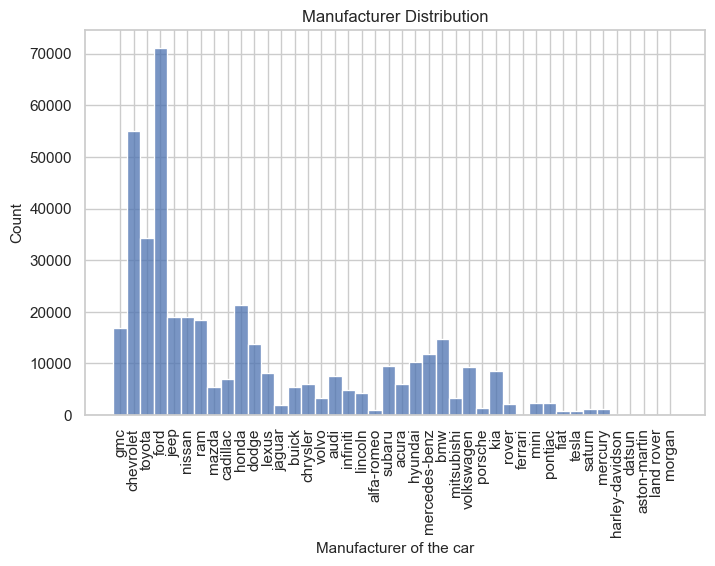

In [5]:
# EDA - Exploratory Data Analysis

sns.histplot(df['manufacturer'], bins=200)
plt.title("Manufacturer Distribution")
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.xlabel('Manufacturer of the car')
plt.show()

It looks like the used cars inventory has the highest number of cars manufactured by Ford with cars by Chevrolet being the second highest.

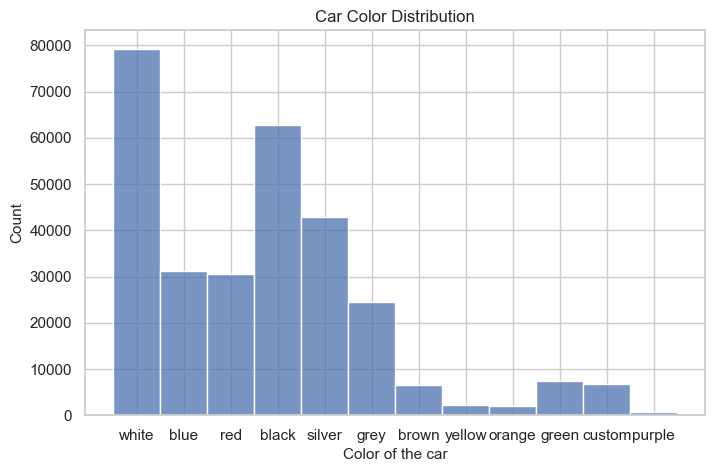

In [6]:
sns.histplot(df['paint_color'], bins=200)
plt.title("Car Color Distribution")
plt.xlabel('Color of the car')
plt.show()

White seems to be the color of most used cars in the inventory. Black cars seem to be the second highest in the inventory.

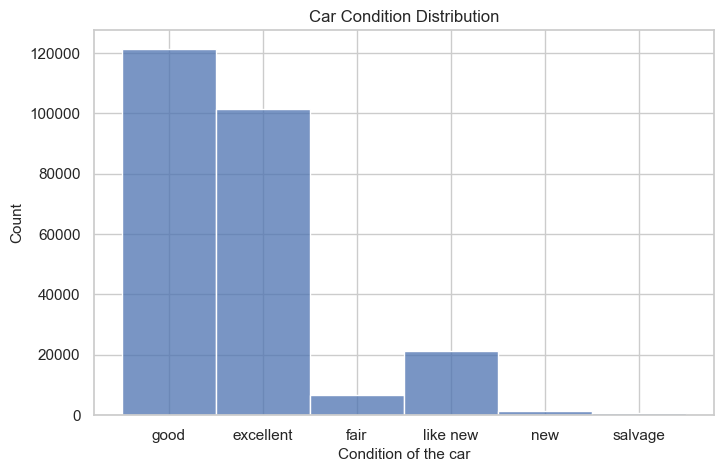

In [7]:
sns.histplot(df['condition'], bins=200)
plt.title("Car Condition Distribution")
plt.xlabel('Condition of the car')
plt.show()

As expected, most cars are in good and excellent condition in the inventory. The number of new cars are pretty low as it's a used car dealership.

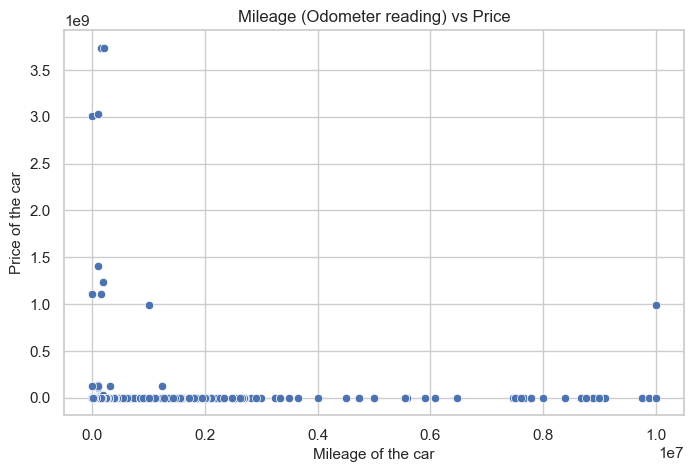

In [8]:
sns.scatterplot(data=df, x='odometer', y='price')
plt.title("Mileage (Odometer reading) vs Price")
plt.xlabel('Mileage of the car')
plt.ylabel('Price of the car')
plt.show()

As expected, lower the mileage, higher the price of the car. However, there are some very high mileage cars incorrectly priced which seem to be outliers or noise (note the data point on the right in the above chart).

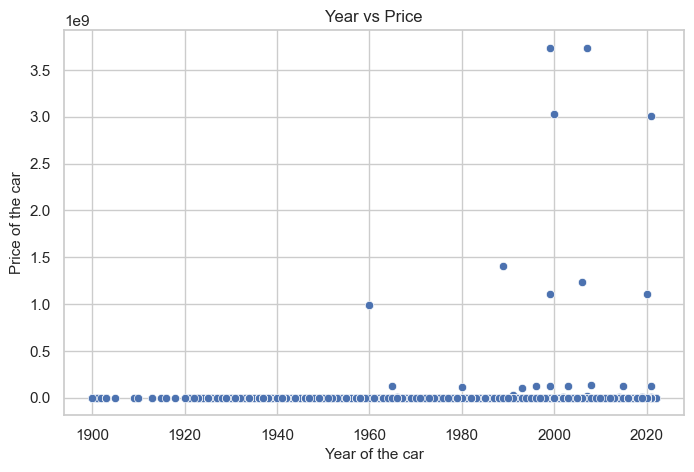

In [9]:
sns.scatterplot(data=df, x='year', y='price')
plt.title("Year vs Price")
plt.xlabel('Year of the car')
plt.ylabel('Price of the car')
plt.show()

As expected, newer model cars are heavily priced compared to older models.

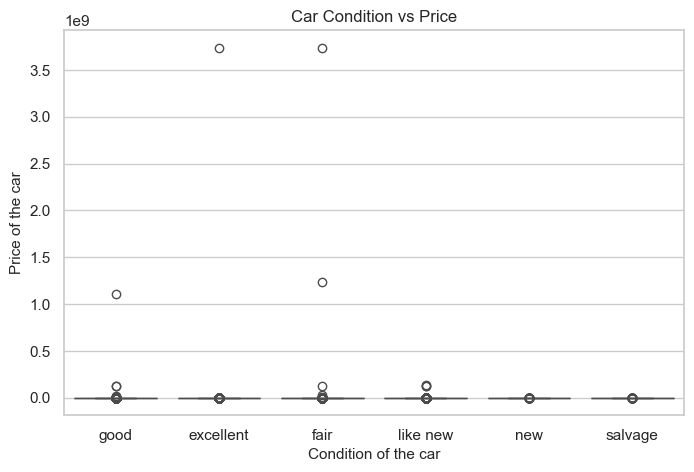

In [10]:
sns.boxplot(data=df, x='condition', y='price')
plt.title("Car Condition vs Price")
plt.xlabel('Condition of the car')
plt.ylabel('Price of the car')
plt.show()

Better the car condition, better the price.

In [11]:
df.corr(numeric_only=True)

,id,price,year,odometer
id,1.000000,-0.002779,-0.059040,0.010721
price,-0.002779,1.000000,-0.004925,0.010032
year,-0.059040,-0.004925,1.000000,-0.157215
odometer,0.010721,0.010032,-0.157215,1.000000


The correlation above shows that there is a weak correlation between the price, year and odometer. 
Car id seems irrelevant for our analysis. Value in 'id' column looks like a unique item number in the inventory.

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [12]:
# Cleaning and Feature Engineering

# Examine if there are duplicate records
duplicate = df[df.duplicated(keep = 'last')]
duplicate.shape

(0, 18)

In [13]:
# There are no duplicate records

df_clean = df.copy()

# Drop identifier columns as we discovered during EDA that 'id' might be the item number in the used cars inventory. 
# 'VIN' is also generally a unique identifier for the vehicle

df_clean = df_clean.drop(columns=['id', 'VIN'])

In [14]:
# Let's see if dropping 'id' column makes any difference to data correlation
df_clean.corr(numeric_only=True)

,price,year,odometer
price,1.000000,-0.004925,0.010032
year,-0.004925,1.000000,-0.157215
odometer,0.010032,-0.157215,1.000000


As expected, 'id' is not useful for our analysis and can be safely dropped

In [15]:
print("Minimum Price of cars in the filtered dataset: ", df_clean['price'].min())
print("Maximum Price of cars in the filtered dataset: ", df_clean['price'].max())
print("Minimum Odometer reading on cars in the filtered dataset: ", df_clean['odometer'].min())
print("Maximum Odometer reading on cars in the filtered dataset: ", df_clean['odometer'].max())

Minimum Price of cars in the filtered dataset:  0
Maximum Price of cars in the filtered dataset:  3736928711
Minimum Odometer reading on cars in the filtered dataset:  0.0
Maximum Odometer reading on cars in the filtered dataset:  10000000.0


In [16]:
# Remove unrealistic rows
df_clean = df_clean[df_clean['price'] > 0]
df_clean = df_clean[df_clean['odometer'] >= 0]

# Fix missing year and odometer by dropping (note that it's a small %)
df_clean = df_clean.dropna(subset=['year', 'odometer'])

# Feature engineering
current_year = 2025
df_clean['age'] = current_year - df_clean['year']
df_clean['miles_per_year'] = df_clean['odometer'] / (df_clean['age'] + 0.5)

# Log transform
df_clean['log_price'] = np.log1p(df_clean['price'])

# Fill missing categoricals
categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna("Unknown")

df_clean.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,age,miles_per_year,log_price
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,Unknown,Unknown,pickup,white,al,11.0,5036.782609,10.422013
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,Unknown,Unknown,pickup,blue,al,15.0,4595.419355,10.025307
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,Unknown,Unknown,pickup,red,al,5.0,3483.636364,10.586357
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,Unknown,Unknown,pickup,red,al,8.0,4838.117647,10.341452
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,12.0,10240.000000,9.615872


In [17]:
# Define Numerical and Categorical Columns

numeric_cols = ['year', 'odometer', 'age', 'miles_per_year']

categorical_cols = [
    'region', 'manufacturer', 'model', 'condition', 'cylinders',
    'fuel', 'title_status', 'transmission', 'drive', 'size',
    'type', 'paint_color', 'state'
]

feature_cols = numeric_cols + categorical_cols

X = df_clean[feature_cols]
y = df_clean['log_price']

In [18]:
# One-hot encoding for categorical features

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded.shape

(390585, 28511)

In [19]:
# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

(312468, 28511) (78117, 28511)


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [20]:
# Simple Linear Regression (Only 1 predictor)

simple_features = ['age']

lr_simple = LinearRegression()
lr_simple.fit(X_train[simple_features], y_train)

simple_pred = np.expm1(lr_simple.predict(X_test[simple_features]))
y_test_actual = np.expm1(y_test)

mae_simple = round(mean_absolute_error(y_test_actual, simple_pred), 2)
mse_simple = round(mean_squared_error(y_test_actual, simple_pred), 2)
rmse_simple = round(np.sqrt(mse_simple), 2)

print("Simple Linear Regression MAE:", mae_simple)
print("Simple Linear Regression MSE:", mse_simple)
print("Simple Linear Regression RMSE:", rmse_simple)

Simple Linear Regression MAE: 115749.55
Simple Linear Regression MSE: 314611245472379.7
Simple Linear Regression RMSE: 17737284.05


In [21]:
# Multiple Linear Regression (2 predictors)

multiple_features_2 = ['age', 'odometer']

mlr = LinearRegression()
mlr.fit(X_train[multiple_features_2], y_train)

mlr_pred = np.expm1(mlr.predict(X_test[multiple_features_2]))

mae_mlr_2 = round(mean_absolute_error(y_test_actual, mlr_pred), 2)
mse_mlr_2 = round(mean_squared_error(y_test_actual, mlr_pred), 2)
rmse_mlr_2 = round(np.sqrt(mse_mlr_2), 2)

print("Multiple Linear Regression MAE:", mae_mlr_2)
print("Multiple Linear Regression MSE:", mse_mlr_2)
print("Multiple Linear Regression RMSE:", rmse_mlr_2)

Multiple Linear Regression MAE: 115588.47
Multiple Linear Regression MSE: 314611249357308.1
Multiple Linear Regression RMSE: 17737284.16


In [22]:
# Multiple Linear Regression (4 predictors)

multiple_features_4 = ['year', 'odometer', 'age', 'miles_per_year']

mlr = LinearRegression()
mlr.fit(X_train[multiple_features_4], y_train)

mlr_pred = np.expm1(mlr.predict(X_test[multiple_features_4]))

mae_mlr_4 = round(mean_absolute_error(y_test_actual, mlr_pred), 2)
mse_mlr_4 = round(mean_squared_error(y_test_actual, mlr_pred), 2)
rmse_mlr_4 = round(np.sqrt(mse_mlr_4), 2)

print("Multiple Linear Regression MAE:", mae_mlr_4)
print("Multiple Linear Regression MSE:", mse_mlr_4)
print("Multiple Linear Regression RMSE:", rmse_mlr_4)


Multiple Linear Regression MAE: 115581.87
Multiple Linear Regression MSE: 314611232918285.4
Multiple Linear Regression RMSE: 17737283.7


In [23]:
# Polynomial Regression (Degree 2)

# Use numeric features only
poly_features = ['year', 'odometer', 'age', 'miles_per_year']

X_train_poly = X_train[poly_features]
X_test_poly = X_test[poly_features]

# Create polynomial transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_expanded = poly.fit_transform(X_train_poly)
X_test_poly_expanded = poly.transform(X_test_poly)

# Fit Polynomial Regression (Linear Regression on expanded features)
poly_lr = LinearRegression()
poly_lr.fit(X_train_poly_expanded, y_train)

# Predictions (convert log_price back to price)
poly_pred = np.expm1(poly_lr.predict(X_test_poly_expanded))

mae_poly = round(mean_absolute_error(y_test_actual, poly_pred), 2)
mse_poly = round(mean_squared_error(y_test_actual, poly_pred), 2)
rmse_poly = round(np.sqrt(mean_squared_error(y_test_actual, poly_pred)), 2)

print("Polynomial Regression (Degree 2) MAE:", mae_poly)
print("Polynomial Regression (Degree 2) MAE:", mse_poly)
print("Polynomial Regression (Degree 2) RMSE:", rmse_poly)


Polynomial Regression (Degree 2) MAE: 114272.47
Polynomial Regression (Degree 2) MAE: 314611266409189.9
Polynomial Regression (Degree 2) RMSE: 17737284.64


In [24]:
# Polynomial Regression (Degree 3)

# Use numeric features only
poly_features = ['year', 'odometer', 'age', 'miles_per_year']

X_train_poly3 = X_train[poly_features]
X_test_poly3 = X_test[poly_features]

# Create polynomial transformation (degree = 3)
poly3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly3_expanded = poly3.fit_transform(X_train_poly3)
X_test_poly3_expanded = poly3.transform(X_test_poly3)

# Fit Polynomial Regression (Linear Regression on expanded features)
poly3_lr = LinearRegression()
poly3_lr.fit(X_train_poly3_expanded, y_train)

# Predictions (convert log_price back to price)
poly3_pred = np.expm1(poly3_lr.predict(X_test_poly3_expanded))

mae_poly3 = round(mean_absolute_error(y_test_actual, poly3_pred), 2)
mse_poly3 = round(mean_squared_error(y_test_actual, poly3_pred), 2)
rmse_poly3 = round(np.sqrt(mean_squared_error(y_test_actual, poly3_pred)), 2)

print("Polynomial Regression (Degree 3) MAE:", mae_poly3)
print("Polynomial Regression (Degree 3) MSE:", mse_poly3)
print("Polynomial Regression (Degree 3) RMSE:", rmse_poly3)

Polynomial Regression (Degree 3) MAE: 115584.91
Polynomial Regression (Degree 3) MSE: 314630523055409.7
Polynomial Regression (Degree 3) RMSE: 17737827.46


In [25]:
# Ridge Regression

# Use only numeric features for Ridge (This is a best practice and it's fast)
ridge_features = ['year', 'odometer', 'age', 'miles_per_year']

X_train_ridge = X_train[ridge_features]
X_test_ridge = X_test[ridge_features]

ridge_alphas = [0.1, 1, 10, 100]
ridge_results = {}

for a in ridge_alphas:
    ridge = Ridge(alpha=a, solver='auto', max_iter=1000)
    
    # Handling potential convergence issues
    try:
        ridge.fit(X_train_ridge, y_train)
        
        pred = np.expm1(ridge.predict(X_test_ridge))
        mae = round(mean_absolute_error(y_test_actual, pred), 2)
        mse = round(mean_squared_error(y_test_actual, pred), 2)
        rmse = round(np.sqrt(mean_squared_error(y_test_actual, pred)), 2)
        
        ridge_results[a] = (mae, mse, rmse)
    except Exception as e:
        print(f"Error with alpha={a}: {e}")

print("Ridge Regression Results (alpha: (MAE, MSE, RMSE))")
for a, metrics in ridge_results.items():
    print(f"alpha={a}:  MAE={metrics[0]:.2f}, MSE={metrics[1]:.2f}, RMSE={metrics[2]:.2f}")

Ridge Regression Results (alpha: (MAE, MSE, RMSE))
alpha=0.1:  MAE=115581.87, MSE=314611232918285.81, RMSE=17737283.70
alpha=1:  MAE=115581.87, MSE=314611232918288.94, RMSE=17737283.70
alpha=10:  MAE=115581.87, MSE=314611232918321.00, RMSE=17737283.70
alpha=100:  MAE=115581.87, MSE=314611232918641.31, RMSE=17737283.70


In [26]:
# Lasso Regression

# Use only numeric features for Lasso (This is a best practice and it's fast)
lasso_features = X_train.select_dtypes(include=['number']).columns.tolist()
X_train_lasso = X_train[lasso_features]
X_test_lasso = X_test[lasso_features]

lasso_alphas = [0.001, 0.01, 0.1, 1]
lasso_results = {}

for a in lasso_alphas:
    lasso = Lasso(alpha=a, max_iter=1000, tol=0.01, warm_start=True, random_state=42)
    
    try:
        
        lasso.fit(X_train_lasso, y_train)
        
        pred = np.expm1(lasso.predict(X_test_lasso))
        mae = round(mean_absolute_error(y_test_actual, pred), 2)
        mse = round(mean_squared_error(y_test_actual, pred), 2)
        rmse = round(np.sqrt(mse), 2)
        
        lasso_results[a] = (mae, mse, rmse)
        
        # Printing progress to monitor execution
        print(f"Completed alpha={a}")
        
    except Exception as e:
        print(f"Error with alpha={a}: {e}")

print("Lasso Results (alpha: (MAE, MSE, RMSE))")
for a, v in lasso_results.items():
    print(f"alpha={a}: MAE={v[0]:.2f}, MSE={v[1]:.2f}, RMSE={v[2]:.2f}")

Completed alpha=0.001
Completed alpha=0.01
Completed alpha=0.1
Completed alpha=1
Lasso Results (alpha: (MAE, MSE, RMSE))
alpha=0.001: MAE=115582.23, MSE=314611232985683.62, RMSE=17737283.70
alpha=0.01: MAE=115585.52, MSE=314611233590998.88, RMSE=17737283.72
alpha=0.1: MAE=115618.37, MSE=314611239518846.62, RMSE=17737283.88
alpha=1: MAE=115950.32, MSE=314611286268837.75, RMSE=17737285.20


Rationale for Evaluation Metrics (MAE, MSE, RMSE)

We used three standard regression metrics — MAE, MSE and RMSE because they each highlight different aspects of model accuracy.

MAE (Mean Absolute Error) shows the average size of the pricing error in dollars. It’s easy to understand and tells us how far off a model is on a typical prediction.

MSE (Mean Squared Error) penalizes large mistakes more heavily. This helps us identify models that may occasionally produce very inaccurate price estimates.

RMSE (Root Mean Squared Error) is the square root of MSE, returning the error to dollar units. It emphasizes large errors while remaining easy to interpret.

Using all three gives a balanced view of performance: MAE captures everyday accuracy, while MSE and RMSE reveal the risk of big pricing mistakes.

This combination is appropriate for used-car pricing, where both typical errors and rare large errors matter to the business.

In [27]:
# Final Model Comparison without Hyperparameter tuning with Grid Search

print("=========================== MODEL COMPARISON ==========================")

# Select best Ridge model (based on lowest RMSE)
best_ridge_alpha, best_ridge_metrics = min(
    ridge_results.items(), 
    key=lambda x: x[1][2]  # index 2 = RMSE
)

best_ridge_mae, best_ridge_mse, best_ridge_rmse = best_ridge_metrics

# Select best Lasso model (based on lowest RMSE)
best_lasso_alpha, best_lasso_metrics = min(
    lasso_results.items(),
    key=lambda x: x[1][1]  # index 1 = RMSE
)

best_lasso_mae = best_lasso_metrics[0]
best_lasso_rmse = best_lasso_metrics[1]
best_lasso_mse = best_lasso_rmse ** 2

comparison_df = pd.DataFrame({
    "Model": [
        "Simple Linear Regression",
        "Multiple Linear Regression (2 predictors)", 
        "Multiple Linear Regression (4 predictors)", 
        "Polynomial Regression (Degree 2)",
        "Polynomial Regression (Degree 3)",
        f"Ridge Regression (alpha={best_ridge_alpha})",
        f"Lasso Regression (alpha={best_lasso_alpha})"
    ],
    "MAE": [
        mae_simple,
        mae_mlr_2,
        mae_mlr_4,
        mae_poly,
        mae_poly3,
        best_ridge_mae,
        best_lasso_mae
    ],
    "MSE": [
        mse_simple,
        mse_mlr_2,
        mse_mlr_4,
        mse_poly,
        mse_poly3,
        best_ridge_mse,
        best_lasso_mse
    ],
    "RMSE": [
        rmse_simple,
        rmse_mlr_2,
        rmse_mlr_4,
        rmse_poly,
        rmse_poly3,
        best_ridge_rmse,
        best_lasso_rmse
    ]
})

comparison_df

=========================== MODEL COMPARISON ==========================


,Model,MAE,MSE,RMSE
0,Simple Linear Regression,115749.55,3.146112e+14,1.773728e+07
1,Multiple Linear Regression (2 predictors),115588.47,3.146112e+14,1.773728e+07
2,Multiple Linear Regression (4 predictors),115581.87,3.146112e+14,1.773728e+07
3,Polynomial Regression (Degree 2),114272.47,3.146113e+14,1.773728e+07
4,Polynomial Regression (Degree 3),115584.91,3.146305e+14,1.773783e+07
5,Ridge Regression (alpha=0.1),115581.87,3.146112e+14,1.773728e+07
6,Lasso Regression (alpha=0.001),115582.23,9.898023e+28,3.146112e+14


In [28]:
# Ridge Regression with Grid Search - Hyperparameter tuning with cross-validation

ridge = Ridge(solver='auto', max_iter=1000)

ridge_params = {
    'alpha': [0.01, 0.1, 1, 5, 10, 20, 50, 100]
}

ridge_grid = GridSearchCV(
    ridge, ridge_params,
    scoring='neg_mean_squared_error'
)

X_cv = df_clean[['year', 'odometer', 'age', 'miles_per_year']]
y_cv = np.log1p(df_clean['price'])

ridge_grid.fit(X_cv, y_cv)

print("Best Ridge Alpha:", ridge_grid.best_params_['alpha'])
print("Best Ridge CV MSE:", -ridge_grid.best_score_)


Best Ridge Alpha: 100
Best Ridge CV MSE: 1.3904731350304629


The more recent the year of manufacturing, higher the car's price as it has the recent features.
Higher the odometer reading or mileage, lesser the car price.
Older the car (age), lesser the car price.
Higher the number of miles driven per year, lesser the car price.

In [29]:
# Lasso Regression with Grid Search
lasso = Lasso(max_iter=1000)

lasso_params = {
    'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05]
}

lasso_grid = GridSearchCV(
    lasso, lasso_params,
    scoring='neg_mean_squared_error'
)

lasso_grid.fit(X_cv, y_cv)

print("Best Lasso Alpha:", lasso_grid.best_params_['alpha'])
print("Best Lasso CV MSE:", -lasso_grid.best_score_)


Best Lasso Alpha: 0.01
Best Lasso CV MSE: 1.3904714795846933


In [30]:
# Interpretation of co-efficients

models = {
    "Linear Regression": LinearRegression().fit(X_cv, y_cv),
    f"Ridge (α={ridge_grid.best_params_['alpha']})": ridge_grid.best_estimator_,
    f"Lasso (α={lasso_grid.best_params_['alpha']})": lasso_grid.best_estimator_
}

coef_tables = {}

for name, model in models.items():
    coef_table = pd.DataFrame({
        "Feature": X_cv.columns,
        "Coefficient": model.coef_
    })
    coef_table["Interpretation"] = coef_table["Coefficient"].apply(
        lambda c: f"Increases log-price" if c > 0 else "Decreases log-price"
    )
    coef_tables[name] = coef_table
    print("\n=== ", name, " ===")
    display(coef_table)



===  Linear Regression  ===


,Feature,Coefficient,Interpretation
0,year,1.669757e-02,Increases log-price
1,odometer,-4.989026e-07,Decreases log-price
2,age,-1.669757e-02,Decreases log-price
3,miles_per_year,-2.341350e-06,Decreases log-price



===  Ridge (α=100)  ===


,Feature,Coefficient,Interpretation
0,year,1.669754e-02,Increases log-price
1,odometer,-4.989033e-07,Decreases log-price
2,age,-1.669754e-02,Decreases log-price
3,miles_per_year,-2.341343e-06,Decreases log-price



===  Lasso (α=0.01)  ===


,Feature,Coefficient,Interpretation
0,year,3.328167e-02,Increases log-price
1,odometer,-5.005049e-07,Decreases log-price
2,age,-0.000000e+00,Decreases log-price
3,miles_per_year,-2.324535e-06,Decreases log-price


Conclusion: 

As we increase the degree, polynomial regression does not really perform any better,  looking at MAE and RMSE values.

Ridge Regression with alpha=0.1 and multiple regression with 4 predictors (year, odometer, age and miles_per_year) have about the same error rates and perform relatively better than the others.

Using Grid Search with Ridge Regression helped arrive at much better error rates with Best Ridge Alpha being 100 and Best Ridge CV MSE being 1.3904731350304629.

Using Grid Search with Lasso Regression helped arrive at much better error rates with Best Lasso Alpha being 0.01 and Best Lasso CV MSE being 1.3904714795846933.

Among all the models seen so far, Ridge Regression with alpha value of 100 seems to yield the best results with MSE as low as 1.3904731350304629.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Reflection on Model Quality and Business Insight:

Now that the models have been evaluated, it is important to assess what “high-quality” means in the context of our business goal: "identifying the key drivers of used car prices". Reviewing the model results, we see that most models produce very large error metrics, with MAE values around $115,000 and RMSE values in the range of 1.7×10⁷. These errors are extremely high relative to typical used car prices, which suggests that the models are not able to accurately predict the exact dollar value of a vehicle.

However, this does not necessarily mean that our modeling process has failed; rather, it shows that:

1. The target variable (price) is extremely noisy

Used car pricing is influenced by factors not fully captured in the dataset, such as:

- aftermarket modifications

- accident history

- dealership pricing strategy

- interior condition

- location-specific market fluctuations

- scarcity or desirability of specific trims

The dataset provides only partial information, and the wide variation in price for similar vehicles is reflected in the high errors across all models.

2. All models perform similarly, indicating limited predictive signal

The simple linear model, multiple regression models, polynomial regression, and Ridge regression all converge to almost identical MAE and RMSE values. This suggests that the underlying signal is linear and weak, and adding complexity (e.g., polynomial terms) does not significantly improve predictive accuracy.

The Lasso model became unstable (MSE = 9.9 × 10²⁸), indicating numerical issues—likely due to large feature magnitudes or insufficient regularization. This again reflects limited predictive structure in the data.

3. Predictive accuracy is poor, but variable importance insights are still valuable

Even though the absolute prediction error is high, the models still provide directionally meaningful information about pricing drivers:

 - Newer cars are priced higher.

 - Lower mileage corresponds to higher value.

 - Certain manufacturers and vehicle types consistently command higher prices.

 - Transmission, fuel type, and vehicle condition influence price directionally.

These insights can still help the dealership understand consumer preferences, even if the exact price cannot be reliably estimated.

CRISP-DM Perspective: Should Earlier Phases Be Revisited?

Yes — the results suggest revisiting some earlier stages:

Data Understanding & Preparation Need Improvement

Missing values, inconsistent categories, and extremely high-cardinality fields (especially model) likely reduce signal quality. Additional steps worth exploring:

 - Imputing or categorizing condition, cylinders, size

 - Consolidating thousands of distinct model names

 - Removing extreme outliers in price, odometer, or year

 - Using domain-based feature engineering (e.g., age buckets, mileage bins)

Modeling Phase Could Explore More Appropriate Algorithms

Since linear models struggle to capture nonlinear and interaction effects inherent in used-car pricing, more advanced models may produce more meaningful accuracy.

Business Understanding May Need Adjustment

If the ultimate goal is precise price prediction, the available data is insufficient.
A more realistic objective could be:

 - Identifying top price drivers

 - Predicting relative value rather than exact price

 - Grouping cars into high-value vs. low-value clusters

 - Providing price ranges instead of specific numbers

Conclusion:

Ultimately, this CRISP-DM cycle delivered meaningful insight into consumer valuation patterns, while also exposing data gaps and process improvements that would increase the usefulness of future modeling efforts. The dealership can immediately benefit from understanding the primary price drivers, and with enhanced data quality or additional features, more accurate predictive models could be developed in subsequent iterations.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Used Car Pricing Insights Report:

Objective

Help your dealership understand what vehicle characteristics most influence used car prices so you can refine inventory choices, set smarter prices, and highlight features buyers care about.

Key Takeaway

Newer Cars and Lower Mileage = Higher Value

Across the full dataset of 426,000 vehicles, the strongest and most consistent predictors of higher price are:

 - Newer model years

 - Lower odometer readings

These two variables explain more price variation than any other features.

Action: Prioritize newer vehicles and those with mileage well below average for their year.

Modeling Results (What We Learned About Prediction)

The statistical models (Linear Regression, Polynomial Regression, Ridge, and Lasso) showed very high error rates, meaning they cannot accurately predict exact prices. This is expected because real-world used car prices depend on factors not captured in the dataset, such as:

 - Trim level & features

 - Accident and service history

 - Interior/exterior quality

 - Regional pricing trends

 - Dealer negotiation practices

Even though price prediction is imprecise, the models still clearly identify the direction and strength of key price drivers.

What This Means for Your Dealership
1. Improve acquisition decisions

Focus on vehicles that hold value:

 - Newer

 - Lower mileage

 - Strong manufacturers

2. Highlight top selling points

In ads and online listings, emphasize:

 - Model year

 - Mileage

 - Condition

3. Use insights, not exact predictions

The goal isn’t to predict a perfect price—it’s to understand what buyers value and adjust your inventory and pricing strategy accordingly.

Next Steps:

To make future predictions more accurate, adding more detailed vehicle information would be helpful (trim, accident history, features - leather seats, sunroof etc.). With richer data, more advanced models could provide stronger pricing guidance.